In [1]:
import numpy as np
import matplotlib.pyplot as plt
%pylab inline

from sklearn.model_selection import KFold

from nltk.corpus import stopwords
from textblob import TextBlob


from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict



from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor

from sklearn.model_selection import RandomizedSearchCV

Populating the interactive namespace from numpy and matplotlib


# Rating Learning and Prediction for Amazon Product Reviews

## Bahman Roostaei

$\textit{December 2016, Galvanize , San Fransisco.} $

In this project we use the reviews of various products submitted by Amazon.com customers to understand the models that can best predict (classify) the ratings. The data are obtained from [here](http://www.cs.jhu.edu/~mdredze/datasets/sentiment/). We first use classification models and calculate the accuracy score and present the confusion matrix. Since this is a multiclass classification we group the ratings that are close to each other (4 and 5) and (1,2). Note that there is no (3) option (see below for the histogram of labels). We then use regressor models to be able to analyze the model by ROC curve.

In [2]:
class review_analysis(object):
    
    def __init__(self,product_name,filename):
        # instanciate the class by giving the product name or the filename in which
        # the train and test files are.
        self.product_name = product_name
        self.filename = filename
        
    def read(self):
        
        # read the Amazon processed files.
        
        with open(self.product_name+'/'+self.filename) as f:
            self._data = f.readlines()
    
        
    
    def process(self,pure_token = False):
         
        # if pure_token = True returns a lisr of single strings each containing all the 
        # tokens (no underscores) repeated in the same number as original review 
        # but stop words removed.
        # In all cases it returns the labels as well.
        
        self._pure_token = pure_token
        data = self._data
        X = [] # X is list of dictionaries (or processed reviewes) in the selected product name.
            
        y = [] # y corresponds to the labels.
        
        for rev in data: 
            rev_dict = defaultdict(int)
            for W in rev.split()[:-1:]:
                key= W.split(':')[0]
                value = int(W.split(':')[1]) 
                rev_dict[key] = value
                
            X.append(rev_dict)
            label = rev.split()[-1].split(':')[1]
            y.append(float(label))
    
        if pure_token:
            stop_words = stopwords.words('English')
            review_nostop = []
            for review in X:
                tokens = []
                for key,value in review.items():
                    key_split = key.split('_')
                    for elem in key_split:
                        if elem not in stop_words:
                            for _ in range(value):
                                tokens.append(elem)
                review_nostop.append(' '.join(tokens))
    
            return review_nostop,y
        else:
            return X,y

### Part 1. Data

Data have been provided as dictionary of joined tokens (bag of bi-grams) for each review. Here we reprocess the data and convert them to a document with $\textit{only tokens with stop words removed}$ as reflected in dictionaries with the corresponding number of times it is repeated. 

We start with the book review and their star ratings:

In [3]:
rva = review_analysis('dvd','train')
rva.read()
X,y = rva.process(pure_token=True)

In [4]:
rva_test = review_analysis('dvd','test')
rva_test.read()
X_test_original,y_test_original = rva.process(pure_token=True)

Here is a sample of the review generated after processing. This set of tokens are not in the human meaningful order.

In [5]:
X[0]

"today's reality fast moving great nail wait moving selection actors exciting partly today's line partly excellent acting partly sci-fi biting acting great great casting top selection life excellent top story biting fast story actors action can't vu blu-ray today's sci-fi partly actors acting reality life sci-fi line exciting casting story line life blu-ray moving action fast action selection deja wait deja vu casting nail biting reality partly partly can't can't wait excellent exciting nail"

The ratings are balanced:

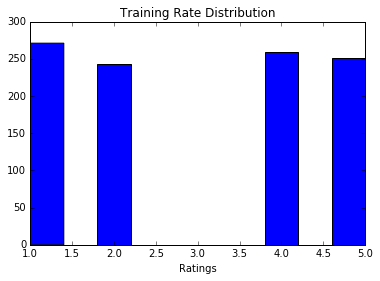

In [6]:
plt.hist(y)
plt.xlabel('Ratings')
plt.title('Training Rate Distribution');

We also can analyze the polarity distribution of the documents and investigate how they are related to the ratings. We use TextBlob:

In [7]:
polarity = []
for i in range(len(y)):
    blob = TextBlob(X[i])
    polarity.append(blob.polarity)

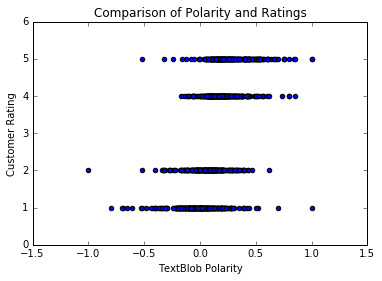

In [8]:
plt.scatter(polarity,y)
plt.xlabel('TextBlob Polarity')
plt.ylabel('Customer Rating')
plt.title('Comparison of Polarity and Ratings');

From the above we observe that the extreme ratings (1,5) cover wider range of polarities.

### Part 2. Classifiers

We use count vectorizing. Note that Tf-idf vectorizing did not improve in any significant order our results that is why we don't present them here. The reason for this is that in understanding the sentiment of a document perhaps certain words (or bi-grams) play the most important way of recognizing the mood of the text.

In [9]:
results_count = defaultdict(float)

In [10]:
kf = KFold(n_splits=5)

Multinomial Bayes is the first model we are going to examine. We use 5-fold split to find the mean accuracy score. Here we use cross-validation over training set. The important point is that we observe that the classifier is not able to very well classify the ratings that are close to each other by 1 unit. That is why we calculate the score by 1 unit of rating difference:

In [11]:
vectorizer_c = CountVectorizer(min_df=1)
vec_train = vectorizer_c.fit_transform(X)
vec_test_original = vectorizer_c.transform(X_test_original)

In [12]:
score = 0
for train_index,test_index in kf.split(vec_train):
    X_train, X_test = vec_train[train_index], vec_train[test_index]
    y_train, y_test = np.array(y)[train_index], np.array(y)[test_index]
    mnb = MultinomialNB()
    mnb.fit(X_train,y_train)
    y_predict = mnb.predict(X_test)
    acc = [1 for i in range(len(y_predict)) if abs(y_predict[i]-y_test[i]) <= 1]
    score += sum(acc)/len(y_predict)
results_count['NB'] = score/5

In [13]:
results_count

defaultdict(float, {'NB': 0.73933046389287438})

In [14]:
threshold = 1
FP = 0
TP = 0
FN = 0
TN = 0
for i in range(len(y_predict)):
    if abs(y_predict[i] - y_test_original[i]) <= threshold and abs(y_predict[i]-5) <= threshold and abs(y_test_original[i]-5) > threshold:
        FP += 1 
    if abs(y_predict[i] - y_test_original[i]) <= threshold  and abs(y_predict[i]-5) <= threshold and abs(y_test_original[i]-5) <= threshold:
        TP += 1 
    if abs(y_predict[i] - y_test_original[i]) <= threshold  and abs(y_predict[i]-1) <= threshold and abs(y_test_original[i]-5) <= threshold:
        FN += 1 
    if abs(y_predict[i] - y_test_original[i]) <= threshold  and abs(y_predict[i]-1) <= threshold and abs(y_test_original[i]-1) <= threshold:
        TN += 1    
        
FP = FP/len(y_predict)
TP = TP/len(y_predict)
FN = FN/len(y_predict)
TN = TN/len(y_predict)

In [15]:
print('Naive Bayes Confusion Matrix:')
print('TN=',TN,'--','FP=',FP)
print('FN=',FN,'--','TP=',TP)

Naive Bayes Confusion Matrix:
TN= 0.3333333333333333 -- FP= 0.0
FN= 0.0 -- TP= 0.18627450980392157


We start the Random Forest and Gradient Boosting classification with default parameters and later on we use randomized grid search to find the best score:

In [16]:
rfc = RandomForestClassifier()
rfc.fit(vec_train,y)
y_predict = rfc.predict(vec_test_original)
acc = [1 for i in range(len(y_predict)) if abs(y_predict[i]-y_test_original[i]) == 0]
score = sum(acc)/len(y_predict)
results_count['RF'] = score

In [17]:
results_count

defaultdict(float, {'NB': 0.73933046389287438, 'RF': 0.98828125})

In [18]:
threshold = 1
FP = 0
TP = 0
FN = 0
TN = 0
for i in range(len(y_predict)):
    if abs(y_predict[i] - y_test_original[i]) <= threshold and abs(y_predict[i]-5) <= threshold and abs(y_test_original[i]-5) <= threshold:
        FP += 1 
    if abs(y_predict[i] - y_test_original[i]) <= threshold  and abs(y_predict[i]-5) <= threshold and abs(y_test_original[i]-5) <= threshold:
        TP += 1 
    if abs(y_predict[i] - y_test_original[i]) <= threshold  and abs(y_predict[i]-1) <= threshold and abs(y_test_original[i]-5) <= threshold:
        FN += 1 
    if abs(y_predict[i] - y_test_original[i]) <= threshold  and abs(y_predict[i]-1) <= threshold and abs(y_test_original[i]-1) <= threshold:
        TN += 1    
        
FP = FP/len(y_predict)
TP = TP/len(y_predict)
FN = FN/len(y_predict)
TN = TN/len(y_predict)

In [19]:
print('Default Random Forest Confusion Matrix:')
print('TN=',TN,'--','FP=',FP)
print('FN=',FN,'--','TP=',TP)

Default Random Forest Confusion Matrix:
TN= 0.5009765625 -- FP= 0.4912109375
FN= 0.0 -- TP= 0.4912109375


In [20]:
mnb = GradientBoostingClassifier()
mnb.fit(vec_train,y)
y_predict = mnb.predict(vec_test_original.toarray())
acc = [1 for i in range(len(y_predict)) if abs(y_predict[i]-y_test_original[i]) == 0]
score = sum(acc)/len(y_predict)
results_count['GB'] = score

In [21]:
results_count

defaultdict(float,
            {'GB': 0.923828125, 'NB': 0.73933046389287438, 'RF': 0.98828125})

In [22]:
threshold = 1
FP = 0
TP = 0
FN = 0
TN = 0
for i in range(len(y_predict)):
    if abs(y_predict[i] - y_test_original[i]) <= threshold and abs(y_predict[i]-5) <= threshold and abs(y_test_original[i]-1) <= threshold:
        FP += 1 
    if abs(y_predict[i] - y_test_original[i]) <= threshold  and abs(y_predict[i]-5) <= threshold and abs(y_test_original[i]-5) <= threshold:
        TP += 1 
    if abs(y_predict[i] - y_test_original[i]) <= threshold  and abs(y_predict[i]-1) <= threshold and abs(y_test_original[i]-5) <= threshold:
        FN += 1 
    if abs(y_predict[i] - y_test_original[i]) <= threshold  and abs(y_predict[i]-1) <= threshold and abs(y_test_original[i]-1) <= threshold:
        TN += 1    
        
FP = FP/len(y_predict)
TP = TP/len(y_predict)
FN = FN/len(y_predict)
TN = TN/len(y_predict)

In [23]:
print('Default Gradient Boost Confusion Matrix:')
print('TN=',TN,'--','FP=',FP)
print('FN=',FN,'--','TP=',TP)

Default Gradient Boost Confusion Matrix:
TN= 0.48046875 -- FP= 0.0
FN= 0.0 -- TP= 0.482421875


In [24]:
random_forest_grid = {'max_depth': [3, None],
                      'max_features': ['sqrt', 'log2', None],
                      'min_samples_split': [1, 2, 4],
                      'bootstrap': [True, False],
                      'n_estimators': [10, 20, 60],
                      'random_state': [1]}

rf_gridsearch = RandomizedSearchCV(RandomForestClassifier(),
                             random_forest_grid,
                             n_jobs=-1,
                             verbose=True,
                             scoring='accuracy')
rf_gridsearch.fit(vec_train,y)
print("best parameters:", rf_gridsearch.best_params_)
best_rf_model = rf_gridsearch.best_estimator_

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   22.4s finished


best parameters: {'min_samples_split': 4, 'max_depth': None, 'bootstrap': True, 'random_state': 1, 'max_features': 'sqrt', 'n_estimators': 60}


In [25]:
y_predict = best_rf_model.predict(vec_test_original)
acc = sum([1 for i in range(len(y_predict)) if abs(y_predict[i]-y_test_original[i])==0])/len(y_predict)
print('Accuracy for best paramter for random forest:',acc)

Accuracy for best paramter for random forest: 1.0


In [26]:
results_count['RF_GridCV'] = acc

In [27]:
results_count

defaultdict(float,
            {'GB': 0.923828125,
             'NB': 0.73933046389287438,
             'RF': 0.98828125,
             'RF_GridCV': 1.0})

In [28]:
threshold = 1
FP = 0
TP = 0
FN = 0
TN = 0
for i in range(len(y_predict)):
    if abs(y_predict[i] - y_test_original[i]) <= threshold and abs(y_predict[i]-5) <= threshold and abs(y_test_original[i]-1) <= threshold:
        FP += 1 
    if abs(y_predict[i] - y_test_original[i]) <= threshold  and abs(y_predict[i]-5) <= threshold and abs(y_test_original[i]-5) <= threshold:
        TP += 1 
    if abs(y_predict[i] - y_test_original[i]) <= threshold  and abs(y_predict[i]-1) <= threshold and abs(y_test_original[i]-5) <= threshold:
        FN += 1 
    if abs(y_predict[i] - y_test_original[i]) <= threshold  and abs(y_predict[i]-1) <= threshold and abs(y_test_original[i]-1) <= threshold:
        TN += 1    
        
FP = FP/len(y_predict)
TP = TP/len(y_predict)
FN = FN/len(y_predict)
TN = TN/len(y_predict)

In [31]:
print('Best Random Forest Confusion Matrix:')
print('TN=',TN,'--','FP=',FP)
print('FN=',FN,'--','TP=',TP)

Best Random Forest Confusion Matrix:
TN= 0.501953125 -- FP= 0.0
FN= 0.0 -- TP= 0.498046875


In [32]:
Gboost_grid = {'max_depth': [3, None],
                      'max_features': ['sqrt', 'log2', None],
                      'min_samples_split': [1,4],
                      'n_estimators': [20, 60],
                      'random_state': [1]}

Gboost_gridsearch = RandomizedSearchCV(GradientBoostingClassifier(),
                             Gboost_grid,
                             n_jobs=-1,
                             verbose=True,
                             scoring='accuracy')
Gboost_gridsearch.fit(vec_train.toarray(),y)
print("best parameters:", Gboost_gridsearch.best_params_)
best_Gboost_model = Gboost_gridsearch.best_estimator_

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 48.2min finished


best parameters: {'min_samples_split': 4, 'random_state': 1, 'max_features': 'sqrt', 'max_depth': None, 'n_estimators': 60}


In [33]:
y_predict = best_Gboost_model.predict(vec_test_original.toarray())
acc = sum([1 for i in range(len(y_predict)) if abs(y_predict[i]-y_test_original[i])==0])/len(y_predict)
print('Accuracy for best paramter for Gboost:',acc)
results_count['GB_GridCV'] = acc

Accuracy for best paramter for Gboost: 1.0


In [34]:
results_count

defaultdict(float,
            {'GB': 0.923828125,
             'GB_GridCV': 1.0,
             'NB': 0.73933046389287438,
             'RF': 0.98828125,
             'RF_GridCV': 1.0})

In [35]:
threshold = 1
FP = 0
TP = 0
FN = 0
TN = 0
for i in range(len(y_predict)):
    if abs(y_predict[i] - y_test_original[i]) <= threshold and abs(y_predict[i]-5) <= threshold and abs(y_test_original[i]-1) <= threshold:
        FP += 1 
    if abs(y_predict[i] - y_test_original[i]) <= threshold  and abs(y_predict[i]-5) <= threshold and abs(y_test_original[i]-5) <= threshold:
        TP += 1 
    if abs(y_predict[i] - y_test_original[i]) <= threshold  and abs(y_predict[i]-1) <= threshold and abs(y_test_original[i]-5) <= threshold:
        FN += 1 
    if abs(y_predict[i] - y_test_original[i]) <= threshold  and abs(y_predict[i]-1) <= threshold and abs(y_test_original[i]-1) <= threshold:
        TN += 1    
        
FP = FP/len(y_predict)
TP = TP/len(y_predict)
FN = FN/len(y_predict)
TN = TN/len(y_predict)

In [36]:
print('Best GBoost Confusion Matrix:')
print('TN=',TN,'--','FP=',FP)
print('FN=',FN,'--','TP=',TP)

Best GBoost Confusion Matrix:
TN= 0.501953125 -- FP= 0.0
FN= 0.0 -- TP= 0.498046875


### Part 3. Regressor

In [37]:
rfc = RandomForestRegressor()
rfc.fit(vec_train,y)
y_predict = rfc.predict(vec_test_original)
acc = [1 for i in range(len(y_predict)) if abs(y_predict[i]-y_test_original[i]) <= 1]
score = sum(acc)/len(y_predict)
results_count['RF_Reg'] = score

In [38]:
results_count

defaultdict(float,
            {'GB': 0.923828125,
             'GB_GridCV': 1.0,
             'NB': 0.73933046389287438,
             'RF': 0.98828125,
             'RF_GridCV': 1.0,
             'RF_Reg': 0.9091796875})

In [39]:
threshold_vals = np.linspace(-6,6,100)
FP_list = []
TP_list = []
for threshold in threshold_vals:
    #threshold = 2
    FP = 0
    for i in range(len(y_predict)):
        if abs(y_predict[i] - y_test_original[i]) <= threshold and abs(y_predict[i]-5) <= threshold and abs(y_test_original[i]-5) > threshold:
            FP += 1 
    FP = FP/len(y_predict)
    TP = 0
    for i in range(len(y_predict)):
        if abs(y_predict[i] - y_test_original[i]) <= threshold  and abs(y_predict[i]-5) <= threshold and abs(y_test_original[i]-5) <= threshold:
            TP += 1 
    TP = TP/len(y_predict)
    FP_list.append(FP)
    TP_list.append(TP)

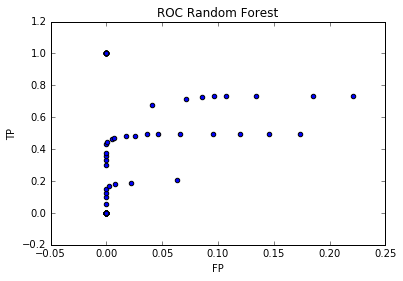

In [40]:
plt.scatter(FP_list,TP_list)
plt.xlabel('FP')
plt.ylabel('TP')
plt.title('ROC Random Forest');

In [41]:
rfc = GradientBoostingRegressor()
rfc.fit(vec_train,y)
y_predict = rfc.predict(vec_test_original.toarray())
acc = [1 for i in range(len(y_predict)) if abs(y_predict[i]-y_test_original[i]) <= 1]
score = sum(acc)/len(y_predict)
results_count['GB_Reg'] = score

In [42]:
results_count

defaultdict(float,
            {'GB': 0.923828125,
             'GB_GridCV': 1.0,
             'GB_Reg': 0.6142578125,
             'NB': 0.73933046389287438,
             'RF': 0.98828125,
             'RF_GridCV': 1.0,
             'RF_Reg': 0.9091796875})

In [43]:
threshold_vals = np.linspace(-6,6,100)
FP_list = []
TP_list = []
for threshold in threshold_vals:
    #threshold = 2
    FP = 0
    for i in range(len(y_predict)):
        if abs(y_predict[i] - y_test_original[i]) <= threshold and abs(y_predict[i]-5) <= threshold and abs(y_test_original[i]-5) > threshold:
            FP += 1 
    FP = FP/len(y_predict)
    TP = 0
    for i in range(len(y_predict)):
        if abs(y_predict[i] - y_test_original[i]) <= threshold  and abs(y_predict[i]-5) <= threshold and abs(y_test_original[i]-5) <= threshold:
            TP += 1 
    TP = TP/len(y_predict)
    FP_list.append(FP)
    TP_list.append(TP)

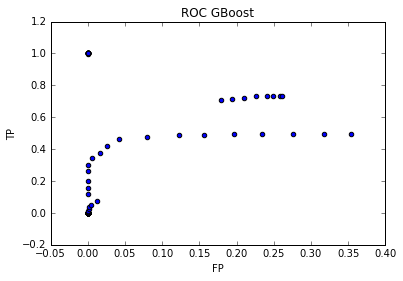

In [44]:
plt.scatter(FP_list,TP_list)
plt.xlabel('FP')
plt.ylabel('TP')
plt.title('ROC GBoost');

### Conclusion

The Boosting and Random Forest classifiers do a great job classifying the ratings with bag of words methods and simple count vectorizing. The major reason for this is that the sentiment of a text is mostly recognized by certain words better than by any long sequence of words. This can be seen as we try to use bag of bi-grams which lowers the accuracy of the model.

It would be very interesting to analyze the review by clustering algorithms such topic modeling and perhaps Kmeans. Clustering will help to predict not only the sentiment of the review but also to specify the product name and by that making recommendation to the customer.